In [1]:
# default_exp geometry.abstract_geometry

# Create abstract geometry

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [3]:
#export
from shapely.geometry import Point, box, Polygon, MultiPoint, MultiPolygon, LineString, MultiLineString
from geocube.api.core import make_geocube
import geopandas as gpd
from scipy import stats
import numpy as np
import pickle

In [5]:
#hide
box_size = (100, 100)
circle_radius_range = (3, 7)
gap = 10
n_circles = 10

In [6]:
#hide
circle_radius = 5

In [7]:
#export
def generate_random_circle_in_box(box_size, circle_radius, gap):
    """distance from box edge is 2xcircel_radius"""
    center_x = np.random.random() * (box_size[0] - 2*(circle_radius + gap)) + (circle_radius + gap)
    center_y = np.random.random() * (box_size[1] - 2*(circle_radius + gap)) + (circle_radius + gap)

    circle = Point(center_x, center_y).buffer(circle_radius)

    return circle

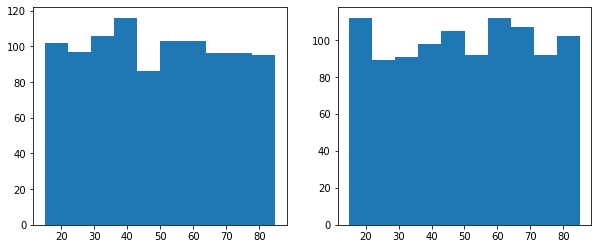

In [8]:
#hide
xs = []
ys = []

for i in range(1000):
    circle = generate_random_circle_in_box(box_size, circle_radius=circle_radius, gap=gap)
    x, y = list(circle.centroid.coords)[0]
    xs.append(x)
    ys.append(y)

_, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].hist(xs)
axs[1].hist(ys);


In [9]:
#export
def has_enough_distance_from_circles(circle, other_circles, gap):
    other_circles = MultiPolygon(other_circles)
    """too close is when they are circle_radius closer"""
    return circle.distance(other_circles) > gap

In [10]:
circles = []
for i in range(10):
    circle = generate_random_circle_in_box(box_size, circle_radius=circle_radius, gap=0)
    circles.append(circle)

circle = generate_random_circle_in_box(box_size, circle_radius=circle_radius, gap=gap)

print("distance to other circles:", [circle.distance(other_circle) for other_circle in circles])
print("has enough distance:", has_enough_distance_from_circles(circle, circles, gap))

distance to other circles: [31.017326389999525, 61.41335046328641, 19.808248632726528, 41.85382656922615, 65.1398741757869, 50.708787924029444, 37.885303554914124, 48.135184629897644, 25.447246588776757, 49.91268533868331]
has enough distance: True


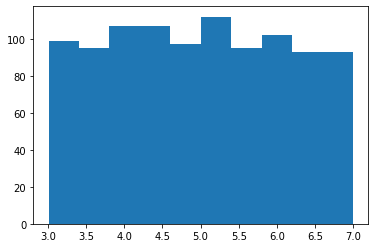

In [11]:
#hide
tmp = [np.random.random()*(circle_radius_range[1] - circle_radius_range[0]) + circle_radius_range[0] for _ in range(1000)]
plt.hist(tmp);
    

In [12]:
#export
def get_random_circle_radius(circle_radius_range):
    return np.random.random()*(circle_radius_range[1] - circle_radius_range[0]) + circle_radius_range[0]

In [19]:
#export
class AbstractGeometry:
    def __init__(self, n_circles, circle_radius_range, box_size, gap, seed):
        self.n_circles = n_circles
        self.box_size = box_size
        self.circle_radius_range = circle_radius_range
        self.gap = gap
        self.seed = seed

    def get_geom_info(self):
        circles = self._generate_random_circles()
        box_coordinates = self._get_box_coordinates()

        return circles, box_coordinates
    
    def _get_box_coordinates(self):
        return [[0, 0], 
                [self.box_size[0], 0], 
                [self.box_size[0], self.box_size[1]], 
                [0, self.box_size[1]]]
    
    def _generate_random_circles(self):
        np.random.seed(self.seed)

        counter = 0
        attempts = 0

        while counter < self.n_circles:
            circle_radius = get_random_circle_radius(self.circle_radius_range)

            if counter == 0 and attempts == 0:
                circle = generate_random_circle_in_box(
                    self.box_size, 
                    circle_radius=circle_radius, 
                    gap=self.gap)

                circles = MultiPolygon([circle])

            attempts += 1
            if attempts > 100 * self.n_circles:
                raise Exception(f'{attempts} attempts, reduce circle radius, increase box size, or decrease number of circles')

            circle = generate_random_circle_in_box(
                self.box_size, 
                circle_radius=circle_radius,
                gap=self.gap)

            if has_enough_distance_from_circles(circle, circles, self.gap):

                circles_tmp = MultiPolygon([g for g in circles.geoms] + [circle])
                if circles_tmp.is_valid:
                    circles = circles_tmp
                    counter += 1
        
        return circles
        
    def save_at(self, path):
        with open(path, 'wb') as handle:
            pickle.dump(self, handle)

In [20]:
abstract_geometry = AbstractGeometry(n_circles, circle_radius_range, box_size, gap, 42)
circles, box_coordinates = abstract_geometry.get_geom_info()

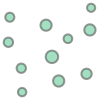

In [21]:
circles

In [22]:
box_coordinates

[[0, 0], [100, 0], [100, 100], [0, 100]]